In [1]:
!pip uninstall tensorflow




^C


In [2]:
!pip install tensorflow

In [89]:
!pip install  ply

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D

C:\Users\Shahbaz\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
import pandas as pd
import re
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
from keras.layers import Input


In [6]:
df = pd.read_csv('MSR_data_cleaned.csv', na_filter=False,nrows=188636)#you can set nrows to the desired value 

C:\Users\Shahbaz\AppData\Local\Temp\ipykernel_6692\2161074731.py:1: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('MSR_data_cleaned.csv', na_filter=False,nrows=188636)#you can set nrows to the desired value


In [ ]:
df.head()

In [ ]:
df.info()

In [7]:
df2 = df[['func_before','func_after','lines_before','lines_after','vul','vul_func_with_fix']]

In [ ]:
df2.head(6)

df2.info()

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
df["Vulnerability Classification"].nunique()

76

# Multiclass Classififcation using Random forest Classifier

In [ ]:
df['func_after'][0]

In [ ]:
df['func_before'][0]

In [ ]:
print(df[['func_before', 'Vulnerability Classification']].tail(8))

In [ ]:
df['Vulnerability Classification'].unique()

In [ ]:
df[['Vulnerability Classification','vul']].iloc[1774]

Pre-processing

In [10]:
df['Vulnerability Classification'].replace('', 'OK', inplace=True)


Filling blank space with "OK" for better understanding of classififcation we don't mean that this blank space is labeld as ok means, we assume that it has a vulnerability that we don't know

In [ ]:
df['Vulnerability Classification'].value_counts()

So this means that the model biasness will be held accountable because of the 
values count. 
Now imagine if a model is trained on 80% of "0" class and 20% on "1" class the model will perform best on "0" class 
So here we need to compromise on the dataset

## Filtering C++ Code 

In [11]:
cpp_func_ptrn = r'\b(?:int|void|char|float|double)\s+\w+\s*\([^)]*\)\s*{'

In [12]:
cpp_func = df[df['func_before'].str.contains(cpp_func_ptrn)]

In [13]:
cpp_func_df = pd.DataFrame(cpp_func[['func_before', 'Vulnerability Classification']])

Now lets see how much vulnerabilities are their in cpp code

In [ ]:
cpp_func_df['Vulnerability Classification'].unique()

In [ ]:
cpp_func_df['Vulnerability Classification'].nunique()

In [2]:
# Count classes
cpp_func_df['Vulnerability Classification'].value_counts()

NameError: name 'cpp_func_df' is not defined

## EDA


In [3]:
#plot
cpp_func_df['Vulnerability Classification'].value_counts().plot(kind='bar', figsize=(12, 6), color='skyblue')
plt.title('Counts of Each Vulnerability Class')
plt.xlabel('Vulnerability Class')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



NameError: name 'cpp_func_df' is not defined

as we can see their can be biasness in the classification model 
for a model to perform significant accurate classifiication  

In [4]:

!pip install imblearn

^C


In [14]:
from imblearn.over_sampling import RandomOverSampler


features = cpp_func_df['func_before'].values.reshape(-1, 1)
target = cpp_func_df['Vulnerability Classification']

# Apply RandomOverSampler
ros = RandomOverSampler(sampling_strategy='not majority')
X_resampled, y_resampled = ros.fit_resample(features, target)


balanced_df = pd.DataFrame({'func_before': X_resampled.flatten(), 'Vulnerability Classification': y_resampled})
print(balanced_df['Vulnerability Classification'].value_counts())

Bypass                                  21081
DoS Exec Code Overflow Mem. Corr.       21081
Exec Code Sql                           21081
DoS Overflow +Priv Mem. Corr. +Info     21081
DoS Overflow Bypass                     21081
                                        ...  
Bypass                                  21081
DoS Overflow                            21081
Overflow                                21081
Overflow +Priv                          21081
Overflow Bypass +Info                   21081
Name: Vulnerability Classification, Length: 70, dtype: int64


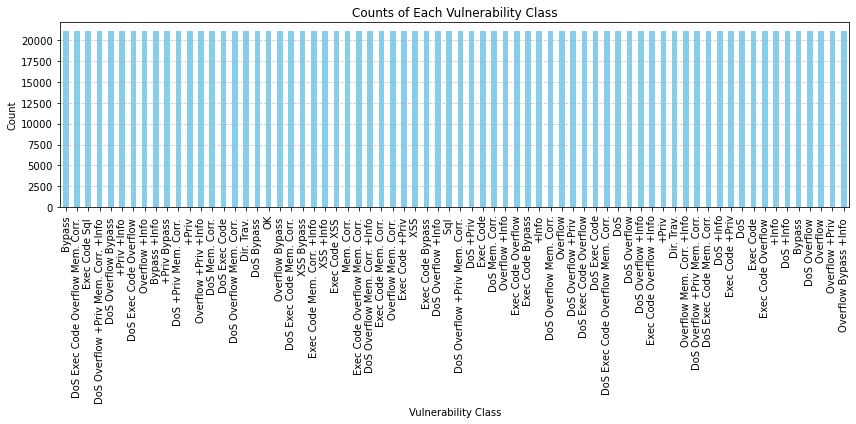

In [54]:
#plot
balanced_df['Vulnerability Classification'].value_counts().plot(kind='bar', figsize=(12, 6), color='skyblue')
plt.title('Counts of Each Vulnerability Class')
plt.xlabel('Vulnerability Class')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

In [51]:
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(balanced_df['func_before'])

nn = NearestNeighbors(n_neighbors=5, algorithm='ball_tree')
nn.fit(X_tfidf)


vulnerable_indices = balanced_df[balanced_df['Vulnerability Classification'] != 'OK'].index
distances, indices = nn.kneighbors(X_tfidf[vulnerable_indices])


top_vulnerable_indices = indices.flatten()
top_vulnerable_codes = balanced_df.iloc[top_vulnerable_indices]

print(top_vulnerable_codes)

C:\Users\Shahbaz\anaconda3\lib\site-packages\sklearn\neighbors\_base.py:504: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


KeyboardInterrupt: 

## Pre-processing

Removing tags ( /n, /t )
for better tokenization

testing 

In [25]:
string = '''static int samldb_add_entry(struct samldb_ctx *ac)\n{\n\tstruct ldb_context 
                    *ldb;\n\tstruct ldb_request *req;\n\tint ret;\n\n\tldb = ldb_module_get_ctx(ac->module);\n\n\tret
                    = ldb_build_add_req(&req, ldb, ac,\n\t\t\t\tac->msg,\n\t\t\t\tac->req->controls,\n\t\t\t\tac, 
                    samldb_add_entry_callback,\n\t\t\t\tac->req);\n\tLDB_REQ_SET_LOCATION(req);\n\tif (ret != LDB_SUCCESS) 
                    {\n\t\treturn ret;\n\t}\n\n\treturn ldb_next_request(ac->module, req);\n}\n'''

# Remove tags
string_cleaned = string.replace('\n', ' ').replace('\t', ' ')

print(string_cleaned)

static int samldb_add_entry(struct samldb_ctx *ac) {  struct ldb_context                      *ldb;  struct ldb_request *req;  int ret;   ldb = ldb_module_get_ctx(ac->module);   ret                     = ldb_build_add_req(&req, ldb, ac,     ac->msg,     ac->req->controls,     ac,                      samldb_add_entry_callback,     ac->req);  LDB_REQ_SET_LOCATION(req);  if (ret != LDB_SUCCESS)                      {   return ret;  }   return ldb_next_request(ac->module, req); } 


In [26]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts([string_cleaned])

print(tokenizer.word_index)

{'ldb': 1, 'ac': 2, 'req': 3, 'ret': 4, 'samldb': 5, 'add': 6, 'struct': 7, 'module': 8, 'int': 9, 'entry': 10, 'ctx': 11, 'request': 12, 'return': 13, 'static': 14, 'context': 15, 'get': 16, 'build': 17, 'msg': 18, 'controls': 19, 'callback': 20, 'set': 21, 'location': 22, 'if': 23, 'success': 24, 'next': 25}


### Here we can se we do not want english tokenizer ,
#### we need cpp lexer which will parse the code in symantic way

In [20]:
def clean_string(func_string):
    # Remove newline /n and tab /t characters
    func_string_cleaned = re.sub(r'[\n\t]', ' ', func_string)
    return func_string_cleaned




In [21]:
balanced_df['func_before'] = balanced_df['func_before'].apply(clean_string)

In [58]:
balanced_df.describe()

,func_before,Vulnerability Classification
count,1475670,1475670
unique,61336,70
top,int gx_device_delete_output_file(const gx_devi...,Bypass
freq,21081,21081


Find max length for embeddig layer 

In [18]:
 max_length = max(len(seq) for seq in balanced_df['func_before'])

print("Maximum sequence length:", max_length)

Maximum sequence length: 240969


### Custom Lexer for C++

In [ ]:

def cpp_tokenizer(code):
    # regex patterns for various token types
    token_specification = [
        ('KEYWORD', r'\b(?:void|int|float|if|else|return|for|while|cout)\b'),  # Keywords
        ('IDENTIFIER', r'\b[A-Za-z_][A-Za-z_0-9]*\b'),  # Identifiers
        ('NUMBER', r'\b\d+\b'),  # Integer literals
        ('OPERATOR', r'[+\-*/=<>!]+'),  # Operators
        ('DELIMITER', r'[{}();,]'),  # Delimiters
        ('WHITESPACE', r'\s+'),  # Whitespace (ignored)
        ('OTHER', r'.'),  # Any other character
    ]
    
    tok_regex = '|'.join('(?P<%s>%s)' % pair for pair in token_specification)
    tokens = []
    for mo in re.finditer(tok_regex, code):
        kind = mo.lastgroup
        value = mo.group(kind)
        if kind != 'WHITESPACE':
            tokens.append(value)
    return tokens

balanced_df['tokens'] = balanced_df['func_before'].apply(cpp_tokenizer)


In [ ]:
balanced_df['tokens']

In [ ]:
sequence_lengths = balanced_df['tokens'].apply(len)


# Plot sequence length 
plt.hist(sequence_lengths, bins=50)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Sequence Length Distribution')
plt.show()

max_len = min(200, sequence_lengths.quantile(0.95))  # Cover 95% of sequences
print(f"Max length: {max_len}")

## word2vec Matrix

In [ ]:

word2vec_model = Word2Vec(sentences=balanced_df['tokens'], vector_size=128, window=5, min_count=1, workers=4)
word2vec_model.save("word2vec_cpp.model")

In [ ]:
max_features = 20000  
max_len = 200   
tokenizer = Tokenizer(num_words=max_features, lower=False, split=' ')
tokenizer.fit_on_texts(balanced_df['tokens'].apply(lambda x: ' '.join(x)))


In [ ]:
word_index = tokenizer.word_index

Embedding matrix 

In [ ]:

embedding_dim = 128
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

for word, i in word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]
    else:
        embedding_matrix[i] = np.random.randn(embedding_dim)

### Padding

In [ ]:

X = tokenizer.texts_to_sequences(balanced_df['tokens'].apply(lambda x: ' '.join(x)))
X = pad_sequences(X, maxlen=max_len)


In [ ]:
num_classes = 70

label endocding on y 

In [ ]:
y = balanced_df['Vulnerability Classification']

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y = y_encoded
y = to_categorical(y_encoded, num_classes=num_classes)


### Train on 10% and Test on 90% 

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=42)

In [32]:
# Build the LSTM model
model = Sequential()
model.add(Embedding(input_dim=len(word_index) + 1,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    input_length=max_len,
                    trainable=False))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(200, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(50, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

C:\Users\Shahbaz\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [33]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.002), metrics=['accuracy'])


In [63]:
model.fit(X_train, y_train, epochs=15, batch_size=32, verbose=2)

Epoch 1/15
192/192 - 83s - 434ms/step - accuracy: 0.3497 - loss: 2.5360
Epoch 2/15
192/192 - 80s - 418ms/step - accuracy: 0.3821 - loss: 2.3166
Epoch 3/15
192/192 - 109s - 568ms/step - accuracy: 0.3929 - loss: 2.2239
Epoch 4/15
192/192 - 92s - 481ms/step - accuracy: 0.4041 - loss: 2.1359
Epoch 5/15
192/192 - 74s - 384ms/step - accuracy: 0.4284 - loss: 2.0433
Epoch 6/15
192/192 - 73s - 381ms/step - accuracy: 0.4384 - loss: 1.9703
Epoch 7/15
192/192 - 70s - 365ms/step - accuracy: 0.4620 - loss: 1.8877
Epoch 8/15
192/192 - 74s - 384ms/step - accuracy: 0.4682 - loss: 1.8180
Epoch 9/15
192/192 - 74s - 386ms/step - accuracy: 0.4843 - loss: 1.7286
Epoch 10/15
192/192 - 71s - 368ms/step - accuracy: 0.5067 - loss: 1.6675
Epoch 11/15
192/192 - 77s - 402ms/step - accuracy: 0.5132 - loss: 1.6090
Epoch 12/15
192/192 - 74s - 385ms/step - accuracy: 0.5337 - loss: 1.5431
Epoch 13/15
192/192 - 73s - 379ms/step - accuracy: 0.5527 - loss: 1.4809
Epoch 14/15
192/192 - 72s - 375ms/step - accuracy: 0.5683 -

In [64]:
unlabeled_data = X_test  
predictions = model.predict(unlabeled_data)
predicted_labels = np.argmax(predictions, axis=1)
confidence_scores = np.max(predictions, axis=1)

1726/1726 ━━━━━━━━━━━━━━━━━━━━ 241s 139ms/step


In [65]:
confidence_threshold = 0.9
confident_indices = np.where(confidence_scores > confidence_threshold)[0]

## Semi-Supervised learning

In [66]:
X_augmented = np.concatenate([X_train, unlabeled_data[confident_indices]])
y_augmented = np.concatenate([y_train, to_categorical(predicted_labels[confident_indices], num_classes)])

In [67]:
model.fit(X_augmented, y_augmented, epochs=15, batch_size=32, verbose=2)

Epoch 1/15
368/368 - 152s - 413ms/step - accuracy: 0.7690 - loss: 0.7752
Epoch 2/15
368/368 - 130s - 355ms/step - accuracy: 0.7759 - loss: 0.7407
Epoch 3/15
368/368 - 152s - 413ms/step - accuracy: 0.7846 - loss: 0.7154
Epoch 4/15
368/368 - 130s - 354ms/step - accuracy: 0.7865 - loss: 0.7003
Epoch 5/15
368/368 - 135s - 366ms/step - accuracy: 0.7878 - loss: 0.6975
Epoch 6/15
368/368 - 131s - 357ms/step - accuracy: 0.7921 - loss: 0.6753
Epoch 7/15
368/368 - 134s - 365ms/step - accuracy: 0.7973 - loss: 0.6540
Epoch 8/15
368/368 - 141s - 384ms/step - accuracy: 0.8004 - loss: 0.6361
Epoch 9/15
368/368 - 135s - 367ms/step - accuracy: 0.8070 - loss: 0.6231
Epoch 10/15
368/368 - 134s - 365ms/step - accuracy: 0.7984 - loss: 0.6321
Epoch 11/15
368/368 - 143s - 389ms/step - accuracy: 0.8130 - loss: 0.5914
Epoch 12/15
368/368 - 126s - 342ms/step - accuracy: 0.8151 - loss: 0.5902
Epoch 13/15
368/368 - 117s - 319ms/step - accuracy: 0.8172 - loss: 0.5754
Epoch 14/15
368/368 - 144s - 391ms/step - accur

till here do it with 19 epochs before augumentation and 10 after aug

### extractiong features for rbf

In [68]:
# Extract features using the trained LSTM model
feature_extractor = Sequential(model.layers[:-2])
X_train_features = feature_extractor.predict(X_augmented)
X_test_features = feature_extractor.predict(X_test)

368/368 ━━━━━━━━━━━━━━━━━━━━ 47s 127ms/step
1726/1726 ━━━━━━━━━━━━━━━━━━━━ 233s 135ms/step


In [69]:
# Converting back to integers 
y_train_rf = np.argmax(y_augmented, axis=1)
y_test_rf = np.argmax(y_test, axis=1)

In [70]:
#consistent number of samples
min_samples = min(X_train_features.shape[0], y_train_rf.shape[0])
X_train_features = X_train_features[:min_samples]
y_train_rf = y_train_rf[:min_samples]


In [71]:
rf_classifier = RandomForestClassifier(n_estimators=512, random_state=42,class_weight='balanced')

In [72]:
rf_classifier.fit(X_train_features, y_train_rf)

RandomForestClassifier(class_weight='balanced', n_estimators=512,
                       random_state=42)

In [73]:
y_pred_rf = rf_classifier.predict(X_test_features)

In [74]:
# Evaluate the model
accuracy = accuracy_score(y_test_rf, y_pred_rf)
print(f'Random Forest Classifier Accuracy: {accuracy}')



Random Forest Classifier Accuracy: 0.45083763470071536


In [198]:
print('Confusion Matrix')
print(confusion_matrix(y_test_rf, y_pred_rf))


Confusion Matrix
[[ 11   0   0 ...   0   0   0]
 [  0 415   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   4]]


In [199]:
print('Classification Report')
print(classification_report(y_test_rf, y_pred_rf))

Classification Report
              precision    recall  f1-score   support

           0       0.15      0.03      0.05       360
           1       0.46      0.11      0.18      3656
           2       0.00      0.00      0.00         5
           3       0.37      0.04      0.07      1266
           4       0.00      0.00      0.00        12
           5       1.00      0.02      0.04        99
           6       0.81      0.18      0.30       160
           7       0.59      0.08      0.13      1024
           8       0.20      0.02      0.03       129
           9       0.00      0.00      0.00         3
          10       0.00      0.00      0.00        86
          11       0.52      0.33      0.41      2070
          12       0.44      0.87      0.58     15285
          13       0.00      0.00      0.00         3
          14       0.44      0.09      0.16       552
          15       0.34      0.03      0.05      1273
          16       0.27      0.01      0.03       206
     

C:\Users\Shahbaz\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Shahbaz\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Shahbaz\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## BOW (bag of words)

In [85]:
max_features= 3000
max_len=100
# bag-of-words vectors
vectorizer = CountVectorizer(max_features=max_features)
vectorizer.fit(cpp_func_df['tokens'].apply(lambda x: ' '.join(x)))
X_bow = vectorizer.transform(cpp_func_df['tokens'].apply(lambda x: ' '.join(x)))

# Split into labeled and unlabeled sets
X_labeled, X_unlabeled, y_labeled, _ = train_test_split(X_bow, y, test_size=0.9, random_state=42)

# Split labeled data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_labeled, y_labeled, test_size=0.1, random_state=42)



In [86]:
# LSTM model
model = Sequential()
model.add(Embedding(input_dim=X_bow.shape[1],  # Vocabulary size
                    output_dim=embedding_dim,
                    input_length=max_len))  # Maximum length of input sequences
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(50, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [87]:

model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=2)



Epoch 1/5
173/173 - 738s - 4s/step - accuracy: 0.3373 - loss: 2.7170
Epoch 2/5
173/173 - 817s - 5s/step - accuracy: 0.3446 - loss: 2.4985
Epoch 3/5
173/173 - 874s - 5s/step - accuracy: 0.3446 - loss: 2.4971
Epoch 4/5
173/173 - 30560s - 177s/step - accuracy: 0.3446 - loss: 2.4907
Epoch 5/5
173/173 - 798s - 5s/step - accuracy: 0.3446 - loss: 2.4941


In [80]:
predictions_unlabeled = model.predict(X_unlabeled)
predicted_labels_unlabeled = np.argmax(predictions_unlabeled, axis=1)
confidence_scores_unlabeled = np.max(predictions_unlabeled, axis=1)



1726/1726 ━━━━━━━━━━━━━━━━━━━━ 2787s 2s/step


In [90]:
confidence_threshold = 0.5
confident_indices = np.where(confidence_scores_unlabeled > confidence_threshold)[0]



In [91]:
if confident_indices.size > 0:
    X_augmented = np.concatenate([X_train, X_unlabeled[confident_indices]])
    y_augmented = np.concatenate([y_train, to_categorical(predicted_labels_unlabeled[confident_indices], num_classes)])
else:
    X_augmented = X_train
    y_augmented = y_train

In [92]:

# LSTM model with augmented training set
model.fit(X_augmented, y_augmented, epochs=5, batch_size=32, verbose=2)


Epoch 1/5
173/173 - 585s - 3s/step - accuracy: 0.3446 - loss: 2.4949
Epoch 2/5
173/173 - 576s - 3s/step - accuracy: 0.3446 - loss: 2.4926
Epoch 3/5
173/173 - 573s - 3s/step - accuracy: 0.3446 - loss: 2.4930
Epoch 4/5
173/173 - 19031s - 110s/step - accuracy: 0.3446 - loss: 2.4921
Epoch 5/5
173/173 - 616s - 4s/step - accuracy: 0.3446 - loss: 2.4900


# TF/IDF

In [117]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

In [113]:
tfidf_vectorizer = TfidfVectorizer(max_features=1000)

In [98]:
cpp_func_df['joined_tokens'] = cpp_func_df['tokens'].apply(lambda x: ' '.join(x))

In [115]:
tfidf_vectorizer = TfidfVectorizer(max_features=2000)  # Reduced number of features
X_tfidf_sparse = tfidf_vectorizer.fit_transform(cpp_func_df['joined_tokens'])


In [118]:
n_components = 100 
svd = TruncatedSVD(n_components=n_components, random_state=42)
X_reduced = svd.fit_transform(X_tfidf_sparse)

In [119]:
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.9, random_state=42)


In [123]:
model = Sequential()
model.add(Input(shape=(X_train.shape[1],)))  # Input layer
model.add(Dense(128, activation='relu'))  # Fully connected layer
model.add(Dropout(0.2))  # Add dropout for regularization
model.add(Dense(50, activation='relu'))  # Fully connected layer
model.add(Dropout(0.2))  # Add another dropout for regularization
model.add(Dense(num_classes, activation='softmax'))  # Output layer

In [124]:
history= model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])


In [126]:
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=2)


Epoch 1/50
192/192 - 1s - 3ms/step - accuracy: 0.4498 - loss: 1.8309
Epoch 2/50
192/192 - 1s - 3ms/step - accuracy: 0.4540 - loss: 1.8293
Epoch 3/50
192/192 - 1s - 3ms/step - accuracy: 0.4620 - loss: 1.8190
Epoch 4/50
192/192 - 1s - 3ms/step - accuracy: 0.4550 - loss: 1.8078
Epoch 5/50
192/192 - 1s - 3ms/step - accuracy: 0.4638 - loss: 1.7968
Epoch 6/50
192/192 - 1s - 3ms/step - accuracy: 0.4591 - loss: 1.7892
Epoch 7/50
192/192 - 1s - 3ms/step - accuracy: 0.4573 - loss: 1.7830
Epoch 8/50
192/192 - 1s - 4ms/step - accuracy: 0.4664 - loss: 1.7651
Epoch 9/50
192/192 - 1s - 6ms/step - accuracy: 0.4685 - loss: 1.7677
Epoch 10/50
192/192 - 1s - 3ms/step - accuracy: 0.4700 - loss: 1.7532
Epoch 11/50
192/192 - 1s - 3ms/step - accuracy: 0.4628 - loss: 1.7449
Epoch 12/50
192/192 - 1s - 3ms/step - accuracy: 0.4791 - loss: 1.7347
Epoch 13/50
192/192 - 1s - 3ms/step - accuracy: 0.4674 - loss: 1.7370
Epoch 14/50
192/192 - 1s - 3ms/step - accuracy: 0.4764 - loss: 1.7299
Epoch 15/50
192/192 - 1s - 3m

In [127]:
# Existing code up to making predictions on the test set
unlabeled_data = X_test
predictions = model.predict(unlabeled_data)
predicted_labels = np.argmax(predictions, axis=1)
confidence_scores = np.max(predictions, axis=1)



1726/1726 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


In [128]:

confidence_threshold = 0.9  

# high-confidence predictions
high_confidence_indices = np.where(confidence_scores >= confidence_threshold)[0]

# Extract
X_pseudo_labeled = X_test[high_confidence_indices]
y_pseudo_labeled = predicted_labels[high_confidence_indices]

# Convert to one-hot encoding
y_pseudo_labeled_one_hot = to_categorical(y_pseudo_labeled, num_classes=num_classes)

# Combine the high-confidence pseudo-labeled data with the original training data
X_train_combined = np.vstack((X_train, X_pseudo_labeled))
y_train_combined = np.vstack((y_train, y_pseudo_labeled_one_hot))


In [131]:
model.fit(X_train_combined, y_train_combined, epochs=75, batch_size=32, verbose=2,validation_split=0.1)


Epoch 1/75
322/322 - 1s - 3ms/step - accuracy: 0.7543 - loss: 0.7527
Epoch 2/75
322/322 - 1s - 4ms/step - accuracy: 0.7559 - loss: 0.7561
Epoch 3/75
322/322 - 1s - 3ms/step - accuracy: 0.7562 - loss: 0.7522
Epoch 4/75
322/322 - 1s - 3ms/step - accuracy: 0.7547 - loss: 0.7457
Epoch 5/75
322/322 - 1s - 3ms/step - accuracy: 0.7562 - loss: 0.7361
Epoch 6/75
322/322 - 1s - 4ms/step - accuracy: 0.7572 - loss: 0.7542
Epoch 7/75
322/322 - 1s - 3ms/step - accuracy: 0.7563 - loss: 0.7396
Epoch 8/75
322/322 - 1s - 3ms/step - accuracy: 0.7554 - loss: 0.7390
Epoch 9/75
322/322 - 1s - 3ms/step - accuracy: 0.7564 - loss: 0.7436
Epoch 10/75
322/322 - 1s - 3ms/step - accuracy: 0.7592 - loss: 0.7454
Epoch 11/75
322/322 - 1s - 3ms/step - accuracy: 0.7597 - loss: 0.7326
Epoch 12/75
322/322 - 1s - 3ms/step - accuracy: 0.7592 - loss: 0.7434
Epoch 13/75
322/322 - 1s - 3ms/step - accuracy: 0.7569 - loss: 0.7342
Epoch 14/75
322/322 - 1s - 3ms/step - accuracy: 0.7593 - loss: 0.7357
Epoch 15/75
322/322 - 1s - 3m

In [132]:
# Re-evaluate the model
predictions_combined = model.predict(X_test)
predicted_labels_combined = np.argmax(predictions_combined, axis=1)
confidence_scores_combined = np.max(predictions_combined, axis=1)


1726/1726 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step


In [137]:
y_test_rf = np.argmax(y_test, axis=1)  # Convert one-hot labels to single class integers for evaluation


In [138]:
accuracy_combined = accuracy_score(y_test_rf, predicted_labels_combined)
print(f'LSTM Model with Pseudo-Labeling Accuracy: {accuracy_combined}')


LSTM Model with Pseudo-Labeling Accuracy: 0.43343294394639137


In [134]:
print('Confusion Matrix')
print(confusion_matrix(y_test_rf, predicted_labels_combined))

Confusion Matrix
[[  43    8    0 ...    2    0    0]
 [   2 1203    0 ...    4    0    0]
 [   0    0    0 ...    0    0    0]
 ...
 [   0    1    0 ...    1    0    0]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0    0]]


In [136]:
print('Classification Report')
print(classification_report(y_test_rf, predicted_labels_combined))

Classification Report
              precision    recall  f1-score   support

           0       0.22      0.11      0.15       378
           1       0.32      0.28      0.30      4360
           2       0.00      0.00      0.00         6
           3       0.20      0.08      0.11      1655
           4       0.14      0.07      0.10        14
           5       1.00      0.02      0.04       101
           6       0.15      0.06      0.09       173
           7       0.22      0.10      0.13      1582
           8       0.04      0.01      0.01       152
           9       0.00      0.00      0.00         6
          10       0.20      0.02      0.03       116
          11       0.42      0.34      0.37      2164
          12       0.52      0.68      0.59     18971
          13       0.00      0.00      0.00         4
          14       0.25      0.16      0.19       582
          15       0.27      0.09      0.14      1369
          16       0.26      0.09      0.13       213
     

C:\Users\Shahbaz\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Shahbaz\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Shahbaz\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
import seaborn as sns

# Train the model initially
history = model.fit(X_train, y_train, epochs=15, batch_size=32, verbose=2, validation_split=0.1)

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Evaluate the model before pseudo-labeling
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)

# Confusion Matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix Before Pseudo-Labeling')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification Report
print('Classification Report Before Pseudo-Labeling')
print(classification_report(np.argmax(y_test, axis=1), predicted_labels))

In [ ]:
history_combined = model.fit(X_train_combined, y_train_combined, epochs=15, batch_size=32, verbose=2, validation_split=0.1)

# Plot training & validation accuracy values after pseudo-labeling
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_combined.history['accuracy'])
plt.plot(history_combined.history['val_accuracy'])
plt.title('Model accuracy after Pseudo-Labeling')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values after pseudo-labeling
plt.subplot(1, 2, 2)
plt.plot(history_combined.history['loss'])
plt.plot(history_combined.history['val_loss'])
plt.title('Model loss after Pseudo-Labeling')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Evaluate the model after pseudo-labeling
predictions_combined = model.predict(X_test)
predicted_labels_combined = np.argmax(predictions_combined, axis=1)

# Confusion Matrix after pseudo-labeling
cm_combined = confusion_matrix(np.argmax(y_test, axis=1), predicted_labels_combined)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_combined, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix After Pseudo-Labeling')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification Report after pseudo-labeling
print('Classification Report After Pseudo-Labeling')
print(classification_report(np.argmax(y_test, axis=1), predicted_labels_combined))